# Diversity of Ideas: Harvard Op-Eds

## 1. Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
from util.ouraws import (
    getFromFile
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
df = getFromFile("../../data/harvard-op-eds.parquet", False)
df.shape


(3026, 6)

In [5]:
df.head(4)

,title,url,body,year,month,day
0,"Allston Is Gentrifying, but Harvard Isn’t To B...",https://www.thecrimson.com/article/2024/3/7/be...,"Allston Is Gentrifying, but Harvard Isn’t To B...",2024,3,1
1,Datamatch’s Flaws Run Deeper Than a Leak,https://www.thecrimson.com/article/2024/3/6/ra...,Datamatch’s Flaws Run Deeper Than a Leak\nBy T...,2024,3,1
2,"This Women’s History Month, I Find Myself in G...",https://www.thecrimson.com/article/2024/3/8/ch...,"This Women’s History Month, I Find Myself in G...",2024,3,1
3,A Safer River Run is a Better River Run,https://www.thecrimson.com/article/2024/3/5/me...,A Safer River Run is a Better River Run\nBy Ju...,2024,3,1


## 2. Function Definitions

In [6]:
import numpy as np
import re

In [7]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [11]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [12]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

### Cynicism related declarations

In [13]:
# Define LIWC-style categories for cynicism analysis
liwc_cynicism = {
    "skepticism": {"skeptical", "doubtful", "unconvinced", "uncertain", "wary", "dubious"},
    "mistrust": {"untrustworthy", "suspicious", "distrustful", "unreliable", "shady", "rigged", "lying"},
    "questionable": {"questionable", "dubious", "problematic", "concerning", "suspect"},
    "dishonesty": {"dishonest", "lie", "lying", "deceptive", "misleading", "false", "fake"},
    "manipulation": {"manipulative", "coercive", "exploitative", "calculated", "scheming"},
    "corruption": {"corrupt", "bribed", "compromised", "unethical", "crooked", "lying"},
    "negativity": {"bad", "worse", "worst", "terrible", "awful", "disastrous", "weird"},
    "certainty": {"obviously", "definitely", "certainly", "undoubtedly", "absolutely", "clearly"}
}

liwc_cynicism_keys = [key for key in liwc_cynicism if key != "certainty"]
liwc_cynicism_keys

['skepticism',
 'mistrust',
 'questionable',
 'dishonesty',
 'manipulation',
 'corruption',
 'negativity']

In [14]:
def liwc_analysis(text):
    """Analyze text using LIWC-style categories for cynicism."""
    tokens = [token.lower() for token in word_tokenize(text) 
              if token.isalnum()]  # Only include alphanumeric tokens
    word_counts = Counter(tokens)
    total_words = sum(word_counts.values())
    
    # Initialize scores dict with all categories
    liwc_scores = {category: 0 for category in liwc_cynicism.keys()}
    
    # Count matches for each category
    for category, words in liwc_cynicism.items():
        category_count = sum(word_counts[word] for word in words if word in word_counts)
        if total_words > 0:
            liwc_scores[category] = round(category_count / total_words, 4)
    
    # Debug print
    # print("LIWC categories found:", list(liwc_scores.keys()))
    
    return liwc_scores

In [15]:
def compute_cynicism_score(row):
    """Compute cynicism score from LIWC categories."""
    # Create a set of categories excluding 'certainty'
    cynicism_categories = set(liwc_cynicism.keys()) - {'certainty'}
    certainty_weight = 1
    
    # Debug print
    # print("Available columns:", row.index.tolist())
    # print("Looking for categories:", list(cynicism_categories))
    
    # Check if all required categories exist
    missing_categories = [cat for cat in cynicism_categories if cat not in row.index]
    if missing_categories:
        print(f"Missing categories: {missing_categories}")
        return 0.0
    
    try:
        cynicism_score = (sum(row[category] for category in cynicism_categories) - 
                         certainty_weight * row["certainty"]) / len(cynicism_categories)
        return round(cynicism_score, 4)
    except Exception as e:
        print(f"Error computing cynicism score: {e}")
        print(f"Row data: {row}")
        return 0.0

In [16]:
def cronbach_alpha(df):
    """Compute Cronbach's Alpha for internal consistency of LIWC categories."""
    # items = df[liwc_cynicism_keys]
    items = df[liwc_cynicism.keys()]
    item_vars = items.var(axis=0, ddof=1)
    total_var = items.sum(axis=1).var(ddof=1)
    n = items.shape[1]
    return (n / (n - 1)) * (1 - sum(item_vars) / total_var)

## 3. LLM Cynicism MFT Analysis

LLM-based cynicism Moral Foundation Theory Analysis

In [17]:
import json
import os
import pprint
from pydantic.v1 import BaseModel, Field
from typing import Dict

from llama_index.core import (
    Settings, 
    SimpleDirectoryReader, 
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage
)
from llama_index.core.prompts import PromptTemplate
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama

In [18]:
class MFTAnalysis(BaseModel):
    authority_subversion: float = Field(
        default=0.0,
        description="Degree of authority skepticism (0.0 to 1.0). Higher values indicate stronger skepticism towards institutional power."
    )
    loyalty_betrayal: float = Field(
        default=0.0,
        description="Degree of perceived betrayal (0.0 to 1.0). Higher values indicate a stronger sense of betrayal or disloyalty towards institutions."
    )
    fairness_injustice: float = Field(
        default=0.0,
        description="Degree of perceived unfairness (0.0 to 1.0). Higher values indicate stronger feelings of injustice or perceived injustice."
    )

class CynicalClassification(BaseModel):
    is_cynical: bool
    reason: str
    mft_analysis: MFTAnalysis = Field(default_factory=MFTAnalysis)
    primary_foundation: str = Field(
        default="",
        description="Dominant moral foundation driving cynicism."
    )
    foundation_explanation: str = Field(
        default="",
        description="Explanation of how the primary moral foundation manifests in the classification."
    )

In [19]:
CYNICISM_CLASSIFICATION_PROMPT = PromptTemplate(
    template="""
You are an expert in cynical classification using Moral Foundations Theory (MFT).
Analyze the text for cynicism through three moral foundations:
1. Authority/Subversion: Skepticism of institutional power, questioning authority
2. Loyalty/Betrayal: Sense of institutional or ideological betrayal
3. Fairness/Injustice: Perceived injustices and inequities

For each foundation, provide a score between 0.0 (not present) and 1.0 (strongly present).
Identify the primary moral foundation driving any cynicism.

## Text to analyze

Text: {text}

## Output Format
You must provide your analysis in a valid JSON structure. Return only valid JSON:

Here is an example of a response about a non-cynical text:
{{{{
    "is_cynical": False,
    "reason": "explanation for the classification",
    "mft_analysis": {{{{
        "authority_subversion": 0.1,
        "loyalty_betrayal": 0.1,
        "fairness_injustice": 0.2
    }}}},
    "primary_foundation": "name of the dominant foundation",
    "foundation_explanation": "explanation of how the primary foundation manifests"
}}}}

Here is an example of cynical judgement about a text:
{{{{
    "is_cynical": True,
    "reason": "explanation for the classification",
    "mft_analysis": {{{{
        "authority_subversion": 0.1,
        "loyalty_betrayal": 0.9,
        "fairness_injustice": 0.1
    }}}},
    "primary_foundation": "name of the dominant foundation",
    "foundation_explanation": "explanation of how the primary foundation manifests"
}}}}
"""
)

In [20]:
# ollama = Ollama(model="deepseek-r1:7b", json_mode=True, temperature=0.0)
ollama = Ollama(model="llama3.2:3b-instruct-q8_0", json_mode=True, temperature=0.0, timeout=240)
ollama.system_prompt=(
    "You are a helpful assistant that always responds with valid JSON matching the requested structure."
)
sllm = ollama.as_structured_llm(output_cls=CynicalClassification, timeout=240)

In [21]:
from llama_index.llms.openai import OpenAI
gpt4omini = OpenAI(model="gpt-4o-mini", temperature=0.0)
gpt4omini.system_prompt=(
    "You are a helpful assistant that always responds with valid JSON matching the requested structure."
)
gpt4omini_sllm = gpt4omini.as_structured_llm(output_cls=CynicalClassification, timeout=120)

In [22]:
def classify_text_cynicism(text) -> CynicalClassification:
    """
    Process a single text and return a CynicalClassification.
    """
    try:
        # Add a more explicit prompt to encourage tool usage
        formatted_prompt = CYNICISM_CLASSIFICATION_PROMPT.format(
            text=text[:1000]  # Limit text length to avoid token limits
        )
        response = gpt4omini_sllm.complete(formatted_prompt)
        return response.raw
    except ValueError as e:
        # Fallback values if tool calls fail
        return CynicalClassification(
            is_cynical=False,
            reason="Error processing text",
            mft_analysis=MFTAnalysis(
                authority_subversion=0.0,
                loyalty_betrayal=0.0,
                fairness_injustice=0.0
            ),
            primary_foundation="none",
            foundation_explanation="Error in processing"
        )

In [23]:
def printCynicalClassification(judgement: CynicalClassification):
    print(f"is_cynical: {judgement.is_cynical}")
    print(f"reason: {judgement.reason}")
    print(f"mft_analysis: {judgement.mft_analysis}")

In [24]:
text = "The police are corrupt and they are not there to protect the people."
judgement = classify_text_cynicism(text)
printCynicalClassification(judgement=judgement)

is_cynical: True
reason: The text expresses a strong distrust of the police, indicating a belief that they are corrupt and not serving their intended purpose of protection, which reflects a cynical view of authority.
mft_analysis: authority_subversion=0.9 loyalty_betrayal=0.8 fairness_injustice=0.7


In [25]:
text = "We like going around theneighborhood."
judgement = classify_text_cynicism(text)
printCynicalClassification(judgement=judgement)

is_cynical: False
reason: The text expresses a neutral sentiment about enjoying the neighborhood without any indication of skepticism towards authority, feelings of betrayal, or perceived injustices.
mft_analysis: authority_subversion=0.0 loyalty_betrayal=0.0 fairness_injustice=0.0


## 4. Diversity Analysis

In [27]:
from openai import OpenAI
from typing import List, Tuple
import numpy as np
client = OpenAI()

In [28]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [29]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [31]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [32]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [33]:
type(wv[0])

list

In [34]:
docmatrix = np.array(wv)

In [35]:
docmatrix.shape

(158, 1024)

In [36]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
3021    2024
3022    2024
3023    2024
3024    2024
3025    2024
Name: year, Length: 160, dtype: int64, 158, 0.0009771213575619248, 0.40941609175834515


In [37]:
# VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
def chunk_process_embeddings(
    clean_df: pd.Series,
    num_chunks: int = 6
) -> List[List[float]]:
    """
    Process embeddings in chunks and combine results.
    
    Args:
        clean_df: pandas Series of cleaned text strings
        num_chunks: number of chunks to process
    
    Returns:
        List[List[float]]: List of embedding vectors, where each vector is a list of floats
    """
    # Calculate chunk size (divide into `num_chunks` equal parts)
    chunk_size = len(clean_df) // num_chunks
    chunk_size = chunk_size if chunk_size > 0 else 1
    
    chunks = [
        clean_df[i:i + chunk_size] 
        for i in range(0, len(clean_df), chunk_size)
    ]
    
    # Process each chunk and combine results
    all_embeddings = []
    for chunk in chunks:
        chunk_embeddings = get_batch_embeddings(chunk)
        all_embeddings.extend(chunk_embeddings)
    
    return all_embeddings

In [39]:
import concurrent.futures

def process_text(text) -> Tuple[bool, float, float, float]:
    """
    Process a single text and return counts based on the classification.
    """
    judgement = classify_text_cynicism(text)
    
    # Access the attributes using dot notation instead of subscripting the MFTAnalysis instance
    return (
        judgement.is_cynical, 
        judgement.mft_analysis.authority_subversion,
        judgement.mft_analysis.loyalty_betrayal,
        judgement.mft_analysis.fairness_injustice
    )

In [40]:
results = []
print(f"{'year':<12}{'size':<12}{'trace':<12}{'pairwise':<12}{'vader':<12}{'lexical':<12}{'cynicism':<12}{'subversion':<12}{'betrayal':<12}{'injustice':<12}")
print("-"*118)
LIWC_SCORE_NAME = "cynicism_lexical"
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = chunk_process_embeddings(clean_df, num_chunks=12)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    # -------------- VADER: Sentiment Analysis ----------------- #
    pos_scores = []
    neg_scores = []
    neu_scores = []
    compound_scores = []
    
    for text in clean_df:
        sentiment_scores = sia.polarity_scores(text)
        pos_scores.append(sentiment_scores['pos'])
        neg_scores.append(sentiment_scores['neg'])
        neu_scores.append(sentiment_scores['neu'])
        compound_scores.append(sentiment_scores['compound']) 
 
    # --------------- LIWC: Lexical Analysis -------------------- #
    temp_df = clean_df.copy()
    
    # Apply LIWC analysis and convert results to separate columns
    liwc_scores = temp_df.apply(liwc_analysis)

    # Convert the series of dictionaries to a DataFrame
    liwc_columns = pd.DataFrame.from_records(liwc_scores.values)
    
    # Combine with original DataFrame
    temp_df = pd.DataFrame(temp_df, columns=['text'])
    liwc_df = pd.concat([temp_df, liwc_columns], axis=1)
    
    # Calculate cynicism score
    liwc_df[LIWC_SCORE_NAME] = liwc_df.apply(compute_cynicism_score, axis=1)
    sum_liwc_score = liwc_df[LIWC_SCORE_NAME].sum()
    
    # ---------------- LLM (Llama) Cynical Classification ---------------- #
    # Use ThreadPoolExecutor to concurrently process texts
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        mft_scores = list(executor.map(process_text, clean_df))

    mft_subversion_score = sum(auth for is_cynical, auth, _, _ in mft_scores if is_cynical) / len(mft_scores)
    mft_betrayal_score   = sum(loyalty for is_cynical, _, loyalty, _ in mft_scores if is_cynical) / len(mft_scores)
    mft_injustice_score  = sum(fairness for is_cynical, _, _, fairness in mft_scores if is_cynical) / len(mft_scores)
    cynicism_score = (mft_subversion_score + mft_betrayal_score + mft_injustice_score) / 3.0
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0],
              'pos': sum(pos_scores) / len(pos_scores),
              'neg': sum(neg_scores) / len(neg_scores),
              'neu': sum(neu_scores) / len(neu_scores),
              'vader': sum(compound_scores) / len(compound_scores),
              'lexical': sum_liwc_score,
              'cynicism': cynicism_score,
              'mft_subversion': mft_subversion_score,
              'mft_betrayal': mft_betrayal_score,
              'mft_injustice': mft_injustice_score,
    }
    results.append(result)
    
    print(f"{year:<12}{cov[0]:<12}{cov[1]:<12.3f}{pairwise:<12.3f}{result['vader']:<12.3f}{result['lexical']:<12.3f}{result['cynicism']:<12.3f}{result['mft_subversion']:<12.3f}{result['mft_betrayal']:<12.3f}{result['mft_injustice']:<12.3f}")

year        size        trace       pairwise    vader       lexical     cynicism    subversion  betrayal    injustice   
----------------------------------------------------------------------------------------------------------------------
2009        35          0.001       0.529       0.629       0.002       0.506       0.540       0.514       0.463       
2010        178         0.001       0.553       0.481       0.019       0.561       0.553       0.584       0.547       
2011        226         0.001       0.535       0.460       0.035       0.545       0.536       0.577       0.523       
2012        264         0.001       0.523       0.469       0.022       0.567       0.535       0.612       0.555       
2013        308         0.001       0.527       0.512       0.057       0.497       0.461       0.534       0.497       
2014        303         0.001       0.522       0.530       0.057       0.524       0.492       0.552       0.528       
2015        167         0.001     

In [41]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm,pos,neg,neu,vader,lexical,cynicism,mft_subversion,mft_betrayal,mft_injustice
year,,,,,,,,,,,,,,,,,
2009,0.528711,35,0.000977,0.000550,0.000478,0.000550,8,0.228571,0.157314,0.101657,0.740886,0.628854,0.0017,0.505714,0.540000,0.514286,0.462857
2010,0.553402,178,0.000977,0.000520,0.000443,0.000520,88,0.494382,0.161067,0.102309,0.736618,0.480627,0.0187,0.561423,0.553371,0.584270,0.546629
2011,0.535163,226,0.000977,0.000551,0.000461,0.000551,133,0.588496,0.167562,0.107513,0.724907,0.460485,0.0346,0.545428,0.536283,0.576991,0.523009
2012,0.523216,264,0.000977,0.000546,0.000471,0.000546,179,0.678030,0.169080,0.110932,0.719989,0.469108,0.0221,0.567298,0.534848,0.612121,0.554924
2013,0.526547,308,0.000977,0.000555,0.000468,0.000555,112,0.363636,0.171773,0.111588,0.716643,0.512056,0.0575,0.497294,0.461039,0.533766,0.497078
2014,0.522198,303,0.000977,0.000577,0.000474,0.000577,156,0.514851,0.173393,0.107832,0.718756,0.529966,0.0572,0.524202,0.492409,0.551815,0.528383
2015,0.490105,167,0.000977,0.000611,0.000506,0.000611,190,1.137725,0.169048,0.117557,0.713383,0.445663,0.0247,0.563273,0.493413,0.619162,0.577246
2016,0.481987,173,0.000977,0.000621,0.000513,0.000621,200,1.156069,0.173439,0.112277,0.714295,0.497475,0.0284,0.539884,0.477457,0.583237,0.558960
2017,0.485297,178,0.000977,0.000594,0.000509,0.000594,190,1.067416,0.159635,0.117404,0.722944,0.355549,0.0238,0.557865,0.483708,0.614045,0.575843


### MFT Analysis with LLM

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import linregress, t

def calculate_regression_stats(x, y):
    """
    Calculate comprehensive regression statistics including confidence intervals.
    
    Args:
        x (array-like): Independent variable values
        y (array-like): Dependent variable values
        
    Returns:
        dict: Dictionary containing regression statistics:
            - slope: Regression slope
            - intercept: Regression intercept 
            - ci_lower: Lower bound of 95% CI
            - ci_upper: Upper bound of 95% CI
            - r_value: R-value (correlation coefficient)
            - p_value: P-value for significance
            - std_err: Standard error of the slope
    """
    # Calculate basic regression statistics
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    degrees_of_freedom = len(x) - 2
    t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_value * std_err
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    
    return {
        'slope': slope,
        'intercept': intercept,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err
    }

def print_regression_stats(x, y, title):
    stats = calculate_regression_stats(x, y)
    print(f"\n{title}:")
    print(f"Slope: {stats['slope']:.5f}")
    print(f"95% CI: ({stats['ci_lower']:.5f}, {stats['ci_upper']:.5f})")
    print(f"R-value: {stats['r_value']:.5f}")
    print(f"P-value: {stats['p_value']:.5f}")
    print(f"Standard Error: {stats['std_err']:.5f}")


Cynicism regression statistics::
Slope: -0.00100
95% CI: (-0.00506, 0.00307)
R-value: -0.13883
P-value: 0.60810
Standard Error: 0.00190

Subversion regression statistics::
Slope: -0.00610
95% CI: (-0.01056, -0.00163)
R-value: -0.61653
P-value: 0.01097
Standard Error: 0.00208

Betrayal regression statistics::
Slope: 0.00139
95% CI: (-0.00318, 0.00597)
R-value: 0.17210
P-value: 0.52391
Standard Error: 0.00213

Injustice regression statistics::
Slope: 0.00172
95% CI: (-0.00250, 0.00594)
R-value: 0.22726
P-value: 0.39729
Standard Error: 0.00197


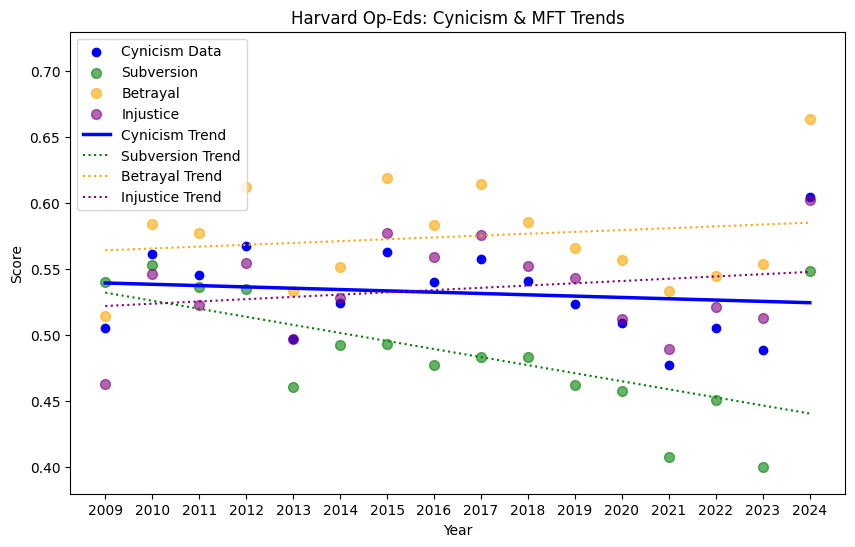

In [45]:
# Define x-axis values as integers
x = results_df['year'].astype(int)

# Rest of regression calculations remain the same
y_cynicism = results_df['cynicism']
slope_c, intercept_c, r_value, p_value, std_err = linregress(x, y_cynicism)
print_regression_stats(x, y_cynicism, "Cynicism regression statistics:")

# Compute regressions for MFT components
y_subversion = results_df['mft_subversion']
slope_auth, intercept_auth, _, _, _ = linregress(x, y_subversion)
print_regression_stats(x, y_subversion, "Subversion regression statistics:")

y_betrayal = results_df['mft_betrayal']
slope_betrayal, intercept_betrayal, _, _, _ = linregress(x, y_betrayal)
print_regression_stats(x, y_betrayal, "Betrayal regression statistics:")

y_injustice = results_df['mft_injustice']
slope_fair, intercept_fair, _, _, _ = linregress(x, y_injustice)
print_regression_stats(x, y_injustice, "Injustice regression statistics:")
# Create plot
plt.figure(figsize=(10, 6))

# Scatter plots
plt.scatter(x, y_cynicism, color='blue', label='Cynicism Data')
plt.scatter(x, y_subversion, color='green', s=50, alpha=0.6, label='Subversion')
plt.scatter(x, y_betrayal, color='orange', s=50, alpha=0.6, label='Betrayal')
plt.scatter(x, y_injustice, color='purple', s=50, alpha=0.6, label='Injustice')

# Trend lines
plt.plot(x, intercept_c + slope_c * x, color='blue', linestyle='-', linewidth=2.5, label='Cynicism Trend')
plt.plot(x, intercept_auth + slope_auth * x, color='green', linestyle=':', linewidth=1.5, label='Subversion Trend')
plt.plot(x, intercept_betrayal + slope_betrayal * x, color='orange', linestyle=':', linewidth=1.5, label='Betrayal Trend')
plt.plot(x, intercept_fair + slope_fair * x, color='purple', linestyle=':', linewidth=1.5, label='Injustice Trend')

# Set integer ticks for x-axis
plt.xticks(x)

# Calculate y-axis limits
all_y_values = np.concatenate([y_cynicism, y_subversion, y_betrayal, y_injustice])
y_min = np.min(all_y_values)
y_max = np.max(all_y_values)

plt.title("Harvard Op-Eds: Cynicism & MFT Trends")
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(loc='upper left')
plt.ylim(y_min * 0.95, y_max * 1.1)
plt.show()

### Regression Goodness of Fit: Explicit Diversity Words

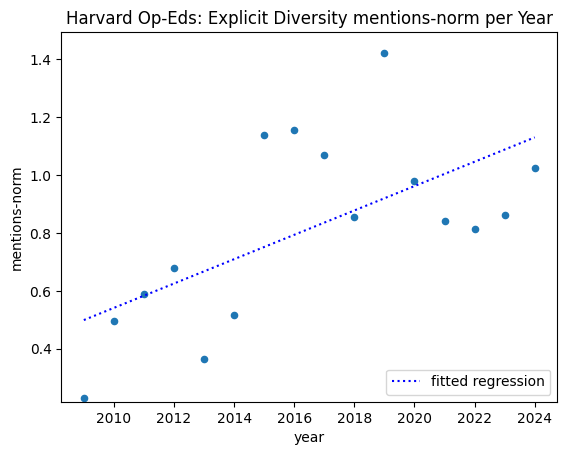

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['mentions-norm']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="mentions-norm", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Op-Eds: Explicit Diversity mentions-norm per Year")
plt.legend(loc='lower right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regression Goodness of Fit: Pairwise Dispersion

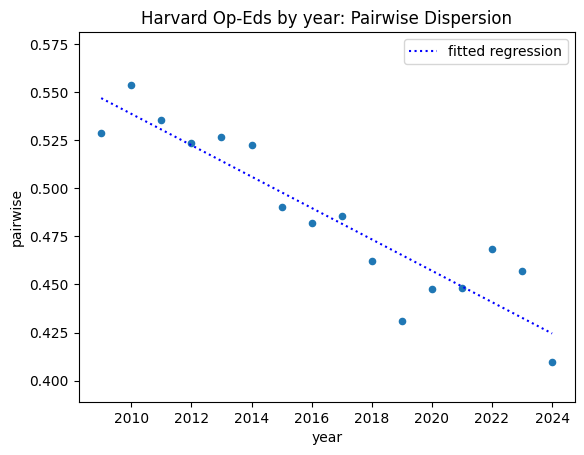

In [48]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Op-Eds by year: Pairwise Dispersion")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regression Goodness of Fit: VADER Sentiment Analysis

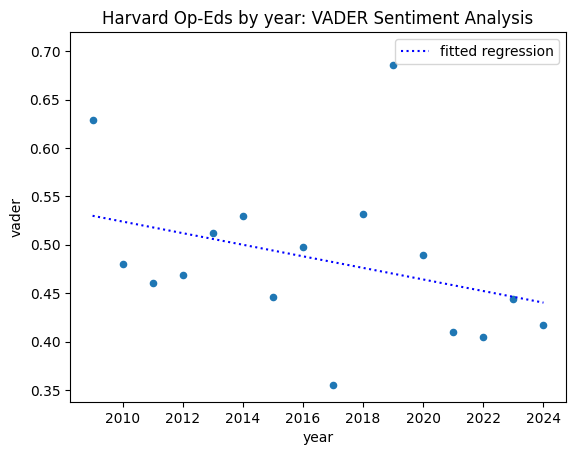

In [49]:
x = results_df['year']
y = results_df['vader']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="vader", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Op-Eds by year: VADER Sentiment Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regression Goodness of Fit: LIWC Lexical Analysis

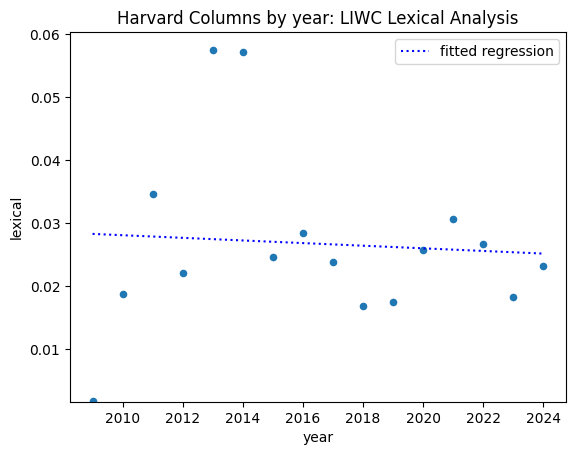

In [50]:
x = results_df['year']
y = results_df['lexical']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="lexical", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Columns by year: LIWC Lexical Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

## Combined Diversity and Sentiment Analyses


mentions-norm metrics:
  slope: 0.04203
  95% CI: (0.01193, 0.07213)
  std error: 0.01403
  p-value: 0.00964
  r-value: 0.62492

pairwise metrics:
  slope: -0.00815
  95% CI: (-0.01013, -0.00617)
  std error: 0.00092
  p-value: 0.00000
  r-value: -0.92068

vader metrics:
  slope: -0.00598
  95% CI: (-0.01539, 0.00342)
  std error: 0.00438
  p-value: 0.19372
  r-value: -0.34277

lexical metrics:
  slope: -0.00021
  95% CI: (-0.00189, 0.00148)
  std error: 0.00079
  p-value: 0.79427
  r-value: -0.07086


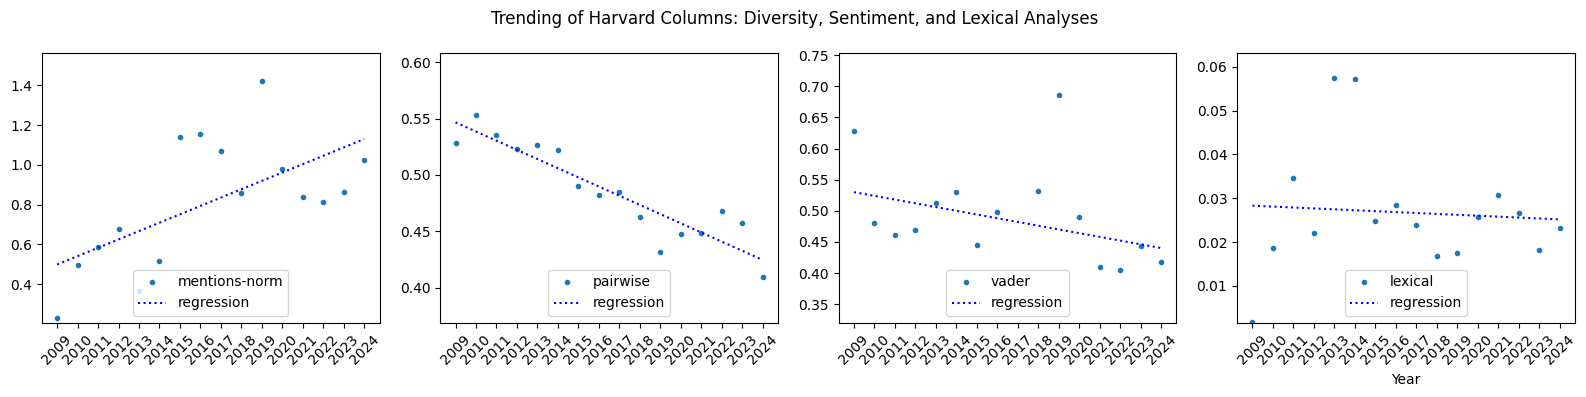

In [51]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "vader", "lexical"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    degrees_of_freedom = len(x) - 2
    t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_value * std_err
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    
    # Print comprehensive statistics
    print(f"\n{column} metrics:")
    print(f"  slope: {slope:.5f}")
    print(f"  95% CI: ({ci_lower:.5f}, {ci_upper:.5f})")
    print(f"  std error: {std_err:.5f}")
    print(f"  p-value: {p_value:.5f}")
    print(f"  r-value: {r_value:.5f}")

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(min(y)*0.9, max(y)*1.1)
    # ax.set_ylim(0.0, 1.0)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    ax.tick_params(axis='x', rotation=45)
    
plt.xlabel("Year")
plt.suptitle("Trending of Harvard Columns: Diversity, Sentiment, and Lexical Analyses")
plt.tight_layout()
plt.show()

In [52]:
from scipy.stats import t, linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: -0.00815
95% Confidence Interval: (-0.01013, -0.00617)
Standard Error: 0.00092
P-value: 0.00000
